# Trainieren eines Classifizierers auf dem STL-10 Datensatz
Der STL-10 Datensatz enthält 10 Klassen. Die Klassifizierer arbeiten jedoch selten mit der textuellen Beschreibung einer Klasse wie z.B. Hund, Katze, Vogel, stattdessen wird jede Klasse mit einer Zahl repräsentiert. Diese Repräsentierung legen wir als erstes fest, da uns dies später einiges erleichtern wird. Wir wählen die lexikographische Sortierung der Klassennamen und indizieren gemäß dieser Reihenfolge. Hierfür verwenden wir ein Dictionary, eine Liste wäre allerdings auch ausreichend.

## Definieren einiger Konstanten
Als nächstes definieren wir den Pfad zu den Bildern *dataset_path* und den Pfad, an dem wir später unsere trainierten Gewichte inkl. Optimiererdaten und Trainingsergebnisse speichern werden *checkpoint_dir*. In dem Verzeichnis, in dem Sie dieses Notebook speichern, wird ein Ordner angelegt mit dem Namen *Checkpoints*. Überprüfen Sie diesen von Zeit zu Zeit und löschen Sie nicht benötigte Checkpoints. Anschließend definieren wir zwei Pfade inkl. Dateinamen für diese Checkpoints. Ein Checkpoint enthält einen Zeitstempel im Dateinamen, der andere nicht. Wenn Sie später ihr Modell testen oder nochmal trainieren möchten, wird immer der Checkpoint ohne Zeitstempel zum Laden verwendet.

In [1]:
import os
import time
import datetime
import torch

# Setze einen Seed für die Reproduzierbarkeit.
torch.manual_seed(1)

class_map_idx_to_str = {0: 'airplane',
                        1: 'bird', 
                        2: 'car', 
                        3: 'cat', 
                        4: 'deer', 
                        5: 'dog', 
                        6: 'horse', 
                        7: 'monkey', 
                        8: 'ship', 
                        9: 'truck'}


# Definiere den Pfad zu den Ordnern train, val und test.
dataset_path = "/home/share/STL10/"


# Definiere den Pfad zu den trainierten Gewichten.
checkpoint_dir = os.getcwd() + os.sep + "Checkpoints" + os.sep

# Auslesen der aktuellen Zeit. Wenn ein neuer Checkpoint erstellt werden soll, muss diese Zelle ausgeführt werden.
date_time = datetime.datetime.fromtimestamp(time.time()).strftime('%Y-%m-%d %H_%M_%S')

checkpoint_save_path_1 = os.getcwd() + "/Checkpoints/checkpoint_[" + date_time + "].pth.tar"
checkpoint_save_path_2 = os.getcwd() + "/Checkpoints/checkpoint.pth.tar"
checkpoint_load_path = checkpoint_save_path_2

# Erstelle einen neuen Ordner Checkpoints im aktuellen Verzeichnis.
if not os.path.isdir(os.getcwd() + "/Checkpoints/"):
    os.makedirs(os.getcwd() + "/Checkpoints/")

# Lade den aktuellen Checkpoint (falls vorhanden), ansonsten erstelle einen neuen.
def create_or_load_checkpoint(model, epoch=-1, optimizer=None, last_loss=10**20):
    if os.path.isfile(checkpoint_load_path):
        print("=> Looking for checkpoint")
        try:
            checkpoint = torch.load(checkpoint_load_path)
            epoch = checkpoint['epoch']
            print("Loaded epoch number is", epoch)            
            last_loss = checkpoint['best_loss']
            print("Loaded best loss is", round(last_loss, 4))
            model.load_state_dict(checkpoint['state_dict'], strict=False)
            if not optimizer is None:
                optimizer.load_state_dict(checkpoint['optimizer'])
            print("=> Found and loaded checkpoint")
        except:
            print("Your checkpoint does not contain trained weights. Your old weights will be overwritten.")
            torch.save({'epoch': epoch, 'state_dict': model.state_dict(), 'best_loss': last_loss, 'optimizer': optimizer.state_dict()}, checkpoint_save_path_1)
            torch.save({'epoch': epoch, 'state_dict': model.state_dict(), 'best_loss': last_loss, 'optimizer': optimizer.state_dict()}, checkpoint_save_path_2)
    else:
        torch.save({'epoch': epoch, 'state_dict': model.state_dict(), 'best_loss': last_loss, 'optimizer': optimizer.state_dict()}, checkpoint_save_path_1)
        torch.save({'epoch': epoch, 'state_dict': model.state_dict(), 'best_loss': last_loss, 'optimizer': optimizer.state_dict()}, checkpoint_save_path_2)
        print("=> No checkpoint found. You have to train first.")
    return epoch, last_loss

# Erstelle einen neuen Checkpoint
def save_checkpoint(model, epoch, optimizer, last_loss):
    # update checkpoint path 1
    date_time = datetime.datetime.fromtimestamp(time.time()).strftime('%Y-%m-%d %H_%M_%S')
    checkpoint_save_path_1 = os.getcwd() + "/Checkpoints/checkpoint_[" + date_time + "].pth.tar"
    
    torch.save({'epoch': epoch, 'state_dict': model.state_dict(), 'best_loss': last_loss, 'optimizer': optimizer.state_dict()}, checkpoint_save_path_1)
    torch.save({'epoch': epoch, 'state_dict': model.state_dict(), 'best_loss': last_loss, 'optimizer': optimizer.state_dict()}, checkpoint_save_path_2)
    
    print("=> Checkpoint saved")

# Bilder laden und Exkurs zu Augmentierungen
Im folgenden Abschnitt laden wir die Bilder. Für größere Projekte definiert man in der Regel noch Augmentierungen, also Funktionen, die die originalen Daten ändern. Hier eine Liste gängiger Augmentierungen:
1. Änderung in Helligkeit, Sättigung und Farbwert: verwende HSV statt RGB und ändere H (Hue), S (Saturation) und V (Value)
2. Rotierung: Bild wird um paar Grad gedreht
3. Verschiebung: Bild wird etwas nach oben, unten, links oder rechts verschoben.
4. Skalierung: Bild wird vergrößert oder verkleinert
5. Scherung: Bild wird geschert: Eine Seite bleibt fest, die gegenüberliegende Seite wird verschoben
6. Random-Flip: Bild wird horizontal oder vertikal gespiegelt
7. Crops: Statt dem gesamten Bild werden dem Modell nur Teile des Bildes gezeigt (meist zufällige Bildausschnitte und mehrere)
8. Rauschen: Auf das Bild wird ein verrauschtes Array addiert

Die Idee der Augmentierung ist, dass man künstlich die Anzahl der Eingabebilder vergrößert. Mittlerweile ist man so weit, dass man neuronale Netze verwendet, sogenannte GANs (Generative Adversarial Network), die für einen gegebenen Datensatz, die Verteilung dieses Datensatzes lernen. Dadurch lassen sich ähnliche, täuschend echte Bilder erzeugen, die wiederum für ein anderes Netz verwendet werden können. Diese Technik verwendet man häufig bei Daten für die es sehr schwer ist gelabelte Daten zu bekommen, z.B. Sensordaten für Aktivitätserkennung.

Da der Fokus hier auf dem Klassifizieren liegt, werden wir nicht weiter darauf eingehen. Bei Interesse dürfen Sie natürlich gerne versuchen Augmentierungen hinzuzufügen. 

In [2]:
import numpy as np
import torchvision


from PIL import Image


# Wir normalisieren die Bilder mit folgenden Werten. Beachte, wegen RGB drei Mittelwerte und drei Standardabweichungen.
means = [0.485, 0.456, 0.406]
stds = [0.229, 0.224, 0.225]

# Wir entscheiden uns hier für eine Batchgröße von 16. Sie können gerne auch größere oder kleinere Batches ausprobieren.
batch_size = 16

# Eine einfache Funktion, die die Bilder läd, normalisiert und zu einem Pytorch-Tensor transformiert.
def simple_dataloader(filename):
    cur_img = Image.open(filename)
    img_as_array = np.array(cur_img)
    
    data_transforms = torchvision.transforms.Compose([
        torchvision.transforms.ToPILImage(),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(mean=means, std=stds),
    ])

    return data_transforms(img_as_array)


# Sammele alle Eingabebilder zusammen mit den Labels (Ordnername)
train_dataset = torchvision.datasets.ImageFolder(dataset_path+"train/", loader=simple_dataloader)
val_dataset = torchvision.datasets.ImageFolder(dataset_path+"val/", loader=simple_dataloader)

# Speichere die Anzahl an Trainings- und Validierungsdaten für die spätere Normierung des Losses.
dataset_sizes = dict()
dataset_sizes["train"] = len(train_dataset)
dataset_sizes["val"] = len(val_dataset)

# Ein Dataloader kann die geladenen Bilder mischen, gruppiert die Bilder zu entsprechenden Batches und lässt die 
# letzte (möglicherweise unvollständige) Batch auf Wunsch entfallen.
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, num_workers=0, shuffle=True, drop_last=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=1, num_workers=1, shuffle=False, drop_last=True)



# Plotten von Zwischenergebnissen
Später, während des Trainings und der Validierung, möchten wir gerne einige Zwischenergebnisse sehen. Hierfür verwenden wir die nachfolgende Methode. Dabei wird in Ihrem Verzeichnis ein Ordner mit dem Namen *Some Results [YYYY-MM-DD HH_MM_SS]* (Zeitstempel kommt von oben) angelegt. Darin finden Sie nach ausreichend langem Training, zwei Unterordner *train* und *val*. Beide Unterordner enthalten die Zwischenergebnisse. Die Dateinamen sehen wie folgt aus:
  
<br>
<center>Epoch_e;cls_i.png</center>

und bedeuten, dass das gezeigte Bild in der Epoche e, Iteration i, als Klasse cls klassifiziert wurde.
<br>  
<br>  
<br>  

## Pytorch Tensoren und ihre Dimensionsreihenfolge
Ein Pytorch Tensor hat in der Regel folgende shape:

<br>
<center>[batch_size, num_channels, height, width]</center>

Das heißt, um ein RGB Bild zu plotten müssen wir uns erst einmal für einen Batchindex entscheiden. Um unnötigen Ärger mit nichtvorhandenen Indizes zu vermeiden, wählen wir im nächsten Abschnitt *batch_idx = 0*, somit bekommen wir auch keinen Fehler, selbst wenn wir mit einer Minibatch von *batch_size = 1* trainieren. Folglich ist *inp* von der Form:

<br>
<center>[num_channels, height, width]</center>

Ein weiterer Unterschied bezüglich der Dimensionsreihenfolge zwischen der Pytorch Tensoren und numpy Arrays ist, dass bei numpy Arrays die Channels am Ende stehen. Um diese Reihenfolge anzupassen, verwenden wir im folgenden:

<br>
<center>inp.transpose((1, 2, 0))</center>

Das heißt die erste Dimension wird an die nullte Dimension, die zeite Dimension an die erste Dimension und die nullte an die zweite Dimension verschoben. Oft spricht man auch von *channel first* oder *channel last*.

<br>
Da die Pytorch Tensoren Float-Tensoren sind, enthalten die Channels Werte zwischen 0 und 1. Wenn wir aber mit PIL (Pillow) ein Bild speichern möchten, müssen wir den Tensor zu einem uint8 Format casten (Restklassenring Z/255Z) und sicherstellen, dass die Werte zwischen 0 und 255 liegen.

In [3]:
def plot_some_results(inputs, preds, class_map, img_counter, epoch, date_time, phase):
    batch_idx = 0
    
    # Den Teil ".cpu().detach()" brauchen wir hier nicht unbedingt, da wir nicht auf einer Grafikkarte arbeiten.
    # Könnte aber für alle interessant sein, die das Zuhause auf ihrem eigenen PC mit GPU Unterstüzung laufen lassen.
    inp = np.array(inputs.cpu().detach().numpy()[batch_idx], dtype=np.float32)
    #inp = np.array(inputs.gpu().detach().numpy()[batch_idx], dtype=np.float32)

    # Da die Bilder zuvor normalisiert wurden, müssen wir dies erst rückgängig machen.
    for channel in range(3):
        inp[channel] = inp[channel] * stds[channel] + means[channel]
        inp[channel] = np.minimum(np.maximum(inp[channel], 0), 1)    
    
    inp = np.array(inp.transpose((1, 2, 0)) * 255.0, dtype=np.uint8)
    class_name = class_map[int(preds[batch_idx])]

    save_dir_results = os.getcwd() + "/Some Results [" + date_time + "]/" + phase + "/"

    if not os.path.isdir(save_dir_results):
        os.makedirs(save_dir_results)

    pil_save_img = Image.fromarray(np.array(inp, dtype=np.uint8))
    pil_save_img.save(save_dir_results + "Epoch_" + str(epoch) + ";" + class_name + "_" + str(img_counter) + ".png")
    img_counter += 1

# Ein Convolutional Neural Network definieren
Im folgenden verwenden wir ein bereits implementiertes CNN (Convolutional Neural Network). Sie können auch gerne andere Netze ausprobieren. [Hier](https://pytorch.org/docs/stable/torchvision/models.html) gibt es einen Überblick über bereits verfügbare Netze. Eine andere Möglichkeit wäre, dass Sie Ihr eigenes Netz implementieren, sehen Sie z.B. [hier](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#define-a-convolutional-neural-network). 
<br>  
Damit unser Modell schneller zu einer akzeptablen Lösung konvergiert, verwenden wir vortrainierte Gewichte. Diese Technik nennt sich Transferlearning. Die Idee ist, dass man ein Netz auf einem anderen (meist sehr viel größeren) Datensatz trainiert und danach auf dem eigenen (meist kleinen) Datensatz anwendet. Dabei spielt es kaum eine Rolle ob die Datensätze ähnlich zueinander sind oder nicht, da die sehr einfachen Feature (z.B. Kanten, Ecken etc) bei vielen Datensätze ähnlich sind. Die Datensätze auf denen zuvor trainiert wurde, haben meist nicht die gleiche Anzahl an Klassen, wie wir sie benötigen. Daher schneiden wir den letzten Layer ab und setzen einen neuen Layer mit der von uns benötigten Anzahl an Klassen bzw Neuronen dran. Der letzte Layer ist bei Klassifizierern in der Regel ein Fully-Connected Layer. Die neu zugewiesene Gewichte kennen wir natürlich nicht und wählen daher eine zufällige Belegung.
<br>  
Im folgenden verwenden wir ResNet34. Dieses Netz enthält 34 Layer. Aus der ResNet Reihe gibt es auch noch ResNet18, ResNet50, ResNet101 und ResNet152. In der Tat hat das ResNet152 exakt 152 Layer und gehört damit zu den tiefsten CNNs. Je tiefer die Netze, desto schwieriger ist es diese zu trainieren. Einerseits akkumulieren sich Fehler sehr schnell zu sehr großen Werten, was wiederum zu sehr großen Gradienten führen kann (auch bekannt als exploding gradients bekannt). Andererseits ist das Training sehr langsam und benötigt darüberhinaus sehr viel Speicher. Wir haben uns für ResNet34 entschieden, da es ein guter Kompromiss zwischen Geschwindigkeit und Genauigkeit ist.

In [4]:
def resnet34(pretrained, num_classes=1000):
    model = torchvision.models.resnet34(pretrained=pretrained)
    num_features = model.fc.in_features
    model.fc = torch.nn.Linear(num_features, num_classes)
    return model

# Implementieren der Trainingsmethode (ToDo)
Im folgenden sollen Sie die Methode zum Trainieren des Klassifizierers vervollständigen. Sie können sich an der Trainingsmethode zur Regression orientieren und auch in den folgenden Tutorials Hinweise finden:
1. [Ein Tutorial über Transferlearning, am Beispiel von Bienen und Ameisen](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html#training-the-model)
2. [Training eines Klassifizierers, am Beispiel von Cifar10](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#train-the-network)

In [5]:
import torch.optim as optim
from torch.optim import lr_scheduler
import copy
import sys

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

epochs = 25
def train_model(num_epochs=epochs):
    since = time.time()
    
    model = resnet34(pretrained=True, num_classes=len(class_map_idx_to_str))
    model = model.to(device)

    # Definieren Sie hier das Loss
    ce_loss = torch.nn.CrossEntropyLoss()

    # Setzen Sie eine Lernrate
    init_lr = 5e-3
    
    # Wählen Sie einen Optimierer
    optimizer = optim.Adam(model.parameters(), init_lr)
    
    # Optional können Sie einen Scheduler für die Lernrate festlegen.
    scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.5)
    
    # Setzen Sie ein Loss, das definitiv größer ist als das erste Validierungsloss.
    last_loss = np.inf
    best_loss = np.inf
    best_acc = 0.0
    
    # Für den Fall, dass wir keinen Checkpoint finden, müssen wir die Startepoche festlegen
    epoch = 0
    
    # Wir versuchen einen Checkpoint zu laden
    print("checkpoint_load_path =", checkpoint_load_path)    
    epoch, last_loss = create_or_load_checkpoint(model, epoch, optimizer, last_loss)
    
    # Implementieren Sie das Training und die Validierung
    
    dataloader = {"train": train_dataloader,                 
                  "val": val_dataloader} 

    for epoch in range(num_epochs):
        
        for phase in ["train", "val"]:
            phase_loss = 0.0
            phase_correct = 0

            if phase == "train":
                model.train()
            else:
                model.eval()

            for i, (images, labels) in enumerate(dataloader[phase]):
                images = images.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(images)
                    _, preds = torch.max(outputs, 1)
                    loss = ce_loss(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                    phase_loss += loss.item() * images.size(0)
                    phase_correct += torch.sum(preds == labels)

            if phase == 'train':
                scheduler.step()
                
            epoch_loss = phase_loss / dataset_sizes[phase]
            epoch_acc = phase_correct.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                   phase, epoch_loss, epoch_acc))
            
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_weights = copy.deepcopy(model.state_dict())
                best_loss = epoch_loss
        
        if epoch % 5 == 0:
            save_checkpoint(model, epoch+1, optimizer, epoch_loss)
            

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best loss Acc: {:4f}'.format(best_acc))
    print('Best loss: {:4f}'.format(best_loss))

    model.load_state_dict(best_model_weights)
    
    save_checkpoint(model, epochs, optimizer, best_loss)

    return model

/usr/local/lib/python3.7/dist-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


In [6]:
torch.cuda.is_available()

False

# Evaluieren des trainierten Modells (ToDo)
Vervollständigen Sie die Methode test_classifier() so, dass eine Confusion Matrix für alle Testbilder berechnet und visualsiert wird. In *all_imgs* sind alle Pfade zu den Testbildern zu finden.  
<br>
Hinweise: 
1. Verwenden Sie die Funktion *simple_dataloader(img_path)* aus der zweiten Zelle (siehe oben), um ein Bild zu laden und einen normalisierten Float-Tensor zurück zu bekommen.
2. Nach Anwenung der Funktion *simple_dataloader* enthalten Ihre Daten noch keine Batches. Verwenden Sie hierzu, ähnlich wie in Aufgabe 6.2 die Methode unsqueeze_(0).

In [25]:
import glob
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, plot_confusion_matrix

def test_model():
    inverted_cls_dict = {value: key for key, value in class_map_idx_to_str.items()}
    num_classes = len(class_map_idx_to_str)
    print("num_classes =", num_classes)
    print("class_map_idx_to_str =", class_map_idx_to_str)
    print("inverted_cls_dict =", inverted_cls_dict)

    all_imgs = [path for path in glob.glob(dataset_path + "test" + os.sep + "*" + os.sep + "*.png")]

    model = resnet34(pretrained=False, num_classes=len(class_map_idx_to_str))
    model = model.to(device)

    # Lade den Checkpoint
    print("checkpoint_load_path =", checkpoint_load_path)
    epoch, last_loss = create_or_load_checkpoint(model)

    # Manche Modelle besitzen Dropout oder eine Batchnorm. Diese verhalten sich im Trainingsmodus anders als im Testmodus.
    # Mit model.eval() legen wir fest, dass wir im Testmodus sind.
    model.eval()    
    
    # Initialisiere ein Array für die Confusion Matrix. Welche Größe hat diese?
    conf_matrix = np.zeros((num_classes, num_classes))
    print(conf_matrix.shape)

    # Itereiere über jedes Element der Liste all_imgs. Lade das korrespondierende Bild und übergib es dem Modell.
    # Woher kennen Sie das Label des Bildes? Nutzen Sie das Dictionary inverted_cls_dict um von der tatsächlichen
    # Klasse zur Klassen-ID zu schließen.
    for image in all_imgs:
        image_tensor = simple_dataloader(image).unsqueeze(0)
        image_tensor = image_tensor.to(device)
        label = image.split('/')[-2]
        label = inverted_cls_dict[label]
        output = model(image_tensor)
        _, prediction = torch.max(output, 1)
        conf_matrix[label, prediction] += 1

    print("\n\nConfusion Matrix =\n", conf_matrix)
    
    # Visualisieren Sie die Confusion Matrix mit matplotlib  
    conf_matrix = conf_matrix.astype(int)
    labels = inverted_cls_dict.keys()

    fig, ax = plt.subplots()
    im = ax.imshow(conf_matrix)

    # We want to show all ticks...
    ax.set_xticks(np.arange(len(labels)))
    ax.set_yticks(np.arange(len(labels)))
    # ... and label them with the respective list entries
    ax.set_xticklabels(labels)
    ax.set_yticklabels(labels)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    for i in range(len(labels)):
        for j in range(len(labels)):
            text = ax.text(j, i, conf_matrix[i, j],
                           ha="center", va="center", color="w")

    ax.set_title("Confusion matrix")
    fig.tight_layout()

    plt.imshow(conf_matrix)
    plt.colorbar()
    plt.ylabel('Ground truth')
    plt.xlabel('Predicted')
    plt.show()
    
    return conf_matrix

# Training und Valdierung starten
Wählen Sie zunächste den Modus *train* aus. Wenn *train = True* trainieren Sie das gewählte Modell. Ein Training mit 10 Epochen und ResNet34 sollte etwa 30 Minuten dauern unter großer Auslastung evtl etwas länger. Wenn Sie ein vortrainiertes Netz und passende Hyperparameter wählen, können Sie bereits nach einer oder zwei Epochen zufriedenstellende Ergebnisse erreichen. Die Testphase sollte sehr viel schneller sein.

num_classes = 10
class_map_idx_to_str = {0: 'airplane', 1: 'bird', 2: 'car', 3: 'cat', 4: 'deer', 5: 'dog', 6: 'horse', 7: 'monkey', 8: 'ship', 9: 'truck'}
inverted_cls_dict = {'airplane': 0, 'bird': 1, 'car': 2, 'cat': 3, 'deer': 4, 'dog': 5, 'horse': 6, 'monkey': 7, 'ship': 8, 'truck': 9}
checkpoint_load_path = /home/melo/Übung 5/Checkpoints/checkpoint.pth.tar
=> Looking for checkpoint
Loaded epoch number is 1
Loaded best loss is 1.3145
=> Found and loaded checkpoint
(10, 10)


Confusion Matrix =
 [[43.  3.  0.  0.  0.  0.  1.  0.  2.  1.]
 [ 7. 10.  0.  8.  8. 10.  0.  6.  1.  0.]
 [ 1.  1. 38.  0.  0.  0.  0.  0.  0. 10.]
 [ 0.  0.  0. 24.  3. 14.  3.  2.  2.  2.]
 [ 2.  0.  0. 13. 19.  8.  7.  0.  0.  1.]
 [ 0.  1.  0. 10.  2. 20. 11.  4.  2.  0.]
 [ 0.  0.  0.  4.  6.  6. 33.  0.  0.  1.]
 [ 1.  2.  0. 10.  6. 18.  2. 11.  0.  0.]
 [13.  2.  4.  0.  0.  1.  0.  1. 27.  2.]
 [ 8.  2.  6.  5.  0.  5.  1.  0.  3. 20.]]


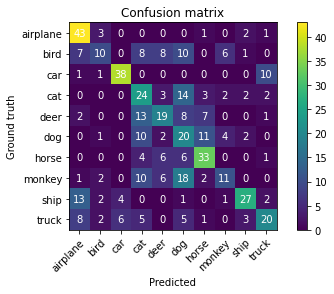

In [26]:
train = False

if train:
    train_model()
else:
    with torch.no_grad():
        test_model()